
> PPO：openai 默认的强化学习算法

- references
    - https://speech.ee.ntu.edu.tw/~tlkagk/courses/MLDS_2018/Lecture/PPO%20(v3).pdf
    - https://openai.com/index/openai-baselines-ppo

In [1]:
from IPython.display import Image

## PG => PPO

> PG + off-policy + constraints => PPO

- PG: $\pi_{\mathbf \theta}(a|s), \pi(a|s;\mathbf\theta)$
    - trajectory $\tau=\{s_1,a_1, s_2,a_2,\cdots, s_T, a_T\}$

    $$
    \begin{split}
    p_\theta(\tau)&=p(s_1)p_\theta(a_1|s_1)p(s_2|s_1,a_1)p_\theta(a_2|s_2)p(s_3|s_2,a_2)\cdots\\
    &=p(s_1)\Pi_{t=1}^Tp_\theta(a_t|s_t)p(s_{t+1}|s_t,a_t)
    \end{split}
    $$

    - $R(\tau)=\sum_{t=1}^Tr_t$
    
    $$
    \begin{split}
    \bar R_\theta&=\sum_{\tau}R(\tau)p_\theta(\tau)\\
    &=\mathbb E_{\tau \sim p_\theta(\tau)}[R(\tau)]
    \end{split}
    $$

    - PG
 
    $$
  \begin{split}
    \nabla \bar R_\theta&=\sum_\tau R(\tau)\nabla p_\theta(\tau)=\sum_\tau R(\tau)p_\theta(\tau)\frac{\nabla p_\theta(\tau)}{p_\theta(\tau)}\\
    &=\sum_\tau R(\tau)p_\theta(\tau)\nabla \log p_\theta(\tau)\\
    &=\mathbb E_{\tau\sim p_\theta(\tau)}[R(\tau)\nabla \log p_\theta(\tau)]\approx \frac1N\sum_{n=1}^N R(\tau^n)\nabla \log p_\theta(\tau^n)\\
    &=\frac1N\sum_{n=1}^N\sum_{t=1}^{T_n}R(\tau^n)\nabla \log p_\theta(a_t^n|s_t^n)\\
    &=\frac1N\sum_{n=1}^N\sum_{t=1}^{T_n}R(\tau^n)\nabla \log \pi_\theta(a_t^n|s_t^n)\\
    &=\frac1N\sum_{n=1}^NR(\tau^n)\sum_{t=1}^{T_n}\nabla \log \pi_\theta(a_t^n|s_t^n)
    \end{split}
    $$


### add a basline

- it is possible that $R(\tau^n)$ is always positive;
    - the probability of the actions not sampled will decrease;
 
    $$
    \begin{split}
    \nabla \bar R_\theta&=\frac1N\sum_{n=1}^N\sum_{t=1}^{T_n}R(\tau^n)\nabla \log \pi_\theta(a_t^n|s_t^n)\\
    &=\frac1N\sum_{n=1}^N\sum_{t=1}^{T_n}(R(\tau^n)-b)\nabla \log \pi_\theta(a_t^n|s_t^n)\\
    &=\frac1N\sum_{n=1}^N(R(\tau^n)-b)\sum_{t=1}^{T_n}\nabla \log \pi_\theta(a_t^n|s_t^n)
    \end{split}
    $$
  
    - $b=\mathbb E[R(\tau)]$

### assign suitable Credit

In [2]:
Image(url='../imgs/s_a_r.png', width=400)

In [3]:
Image(url='../imgs/suitable_credit.png', width=400)

In [4]:
Image(url='../imgs/discounted_reward.png', width=400)

- $R(\tau^n)-b$ 这一项也可以是 state-dependent 的，此时称其为 Advantange function $A^\theta(s_t,a_t)$
    - $A^\theta(s_t,a_t)$ measures how good it is if we take $a_t$ other than other actions at $s_t$
    - Estimated by "Critic" (Actor-Critic)

## On-policy to Off-policy

- On-policy：The agent learned and the agent interacting with the env is the **same**;
    - 一边跟环境互动，一边在学习；
- Off-policy：The agent learned and the agent interacting with the env is **different**;
    - 看别人跟环境互动 (generate demonstration)，再学习；

$$
\nabla \bar R(\theta)=\mathbb E_{\tau\sim p_\theta(\tau)}[R(\tau)\nabla \log p_\theta(\tau)]
$$

- $\pi_\theta$ to collect data, when $\theta$ is updated, we have to sampling training data again;
    - 这是一个数据利用效率的问题

### Importance sampling：重要性采样

$$
E_{x\sim p}f(x)\approx\frac1N\sum_{i=1}^Nf(x^i), \quad x^i\sim p(x)
$$

- 如果我们没办法直接从 $p(x)$ 中采样数据，我们仅可以从 $q(x)$ 中采样数据，$x^i\sim q(x)$

$$
\begin{split}
E_{x\sim p}[f(x)]&=\int f(x)p(x)dx=\int f(x)\frac{p(x)}{q(x)}q(x)dx\\
&=E_{x\sim q}[f(x)\frac{p(x)}{q(x)}]
\end{split}
$$

- 期望相同，但方差不同

    $$
    E_{x\sim p}[f(x)]=E_{x\sim q}[f(x)\frac{p(x)}{q(x)}]
    $$

    $$
    \begin{split}
    \text{Var}_{x\sim q}[f(x)\frac{p(x)}{q(x)}]&=E_{x\sim q}[(f(x)\frac{p(x)}{q(x)})^2]-(E_{x\sim q}[f(x)\frac{p(x)}{q(x)}])^2\\
    &=E_{x\sim p}[f^2(x)\frac{p(x)}{q(x)}] - (E_{x\sim p}[f(x)])^2
    \end{split}
    $$

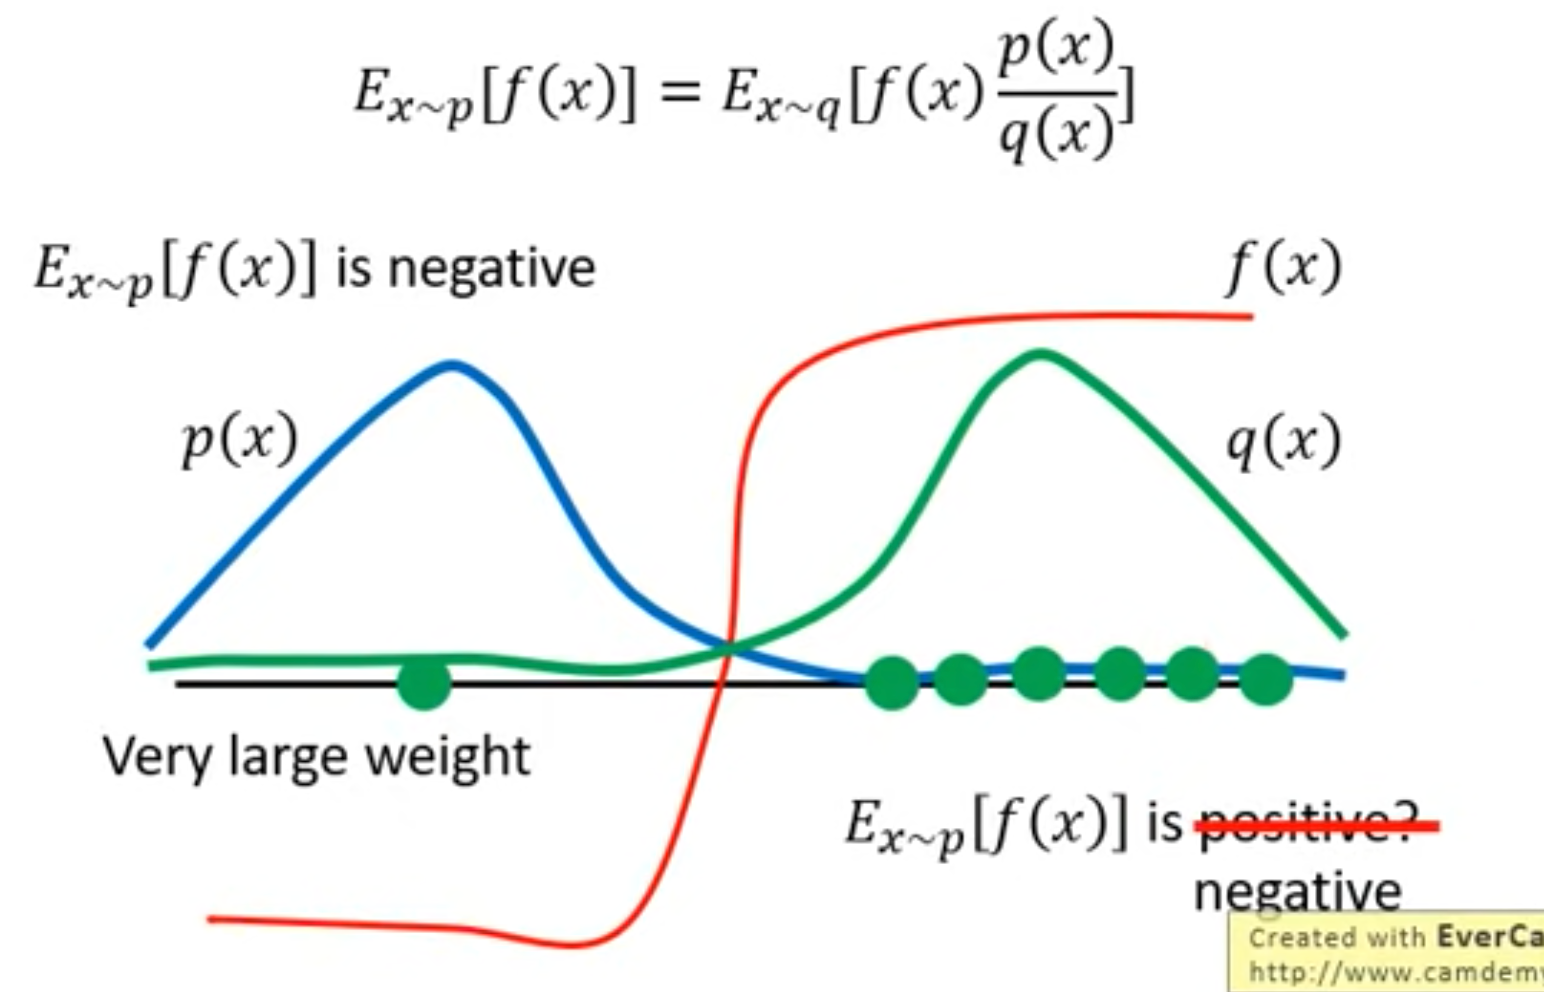

In [6]:
Image('../imgs/importance_sampling_issue.png', width=400)

- 如图所示，虽然均值相同，但因为方差不同，导致当采样次数不够多时，$E_{x\sim p}$ 可能与 $E_{x\sim q}$ 两者期望值的符号都不相同；

$$
\begin{split}
\nabla \bar R_\theta=\mathbb E_{\tau\sim p_\theta(\tau)}[R(\tau)\nabla \log p_\theta(\tau)]\\
\nabla \bar R_\theta=\mathbb E_{\tau\sim p_{\theta'}(\tau)}[\frac{p_\theta(\tau)}{p_{\theta'}(\tau)}R(\tau)\nabla \log p_\theta(\tau)]\\
\end{split}
$$

- using the sample from $\pi_{\theta'}$ to train $\theta$. $\theta'$ is fixed, so we can re-use the sample again.
    - 用 $\pi_{\theta'}$ 跟环境做互动，产生 demonstration
- sample data from $\theta'$ ($\pi_{\theta'}$). Use the data to train $\theta$ many times.

## Off-policy PG

$$
\begin{split}
&=\mathbb E_{(s_t,a_t)\sim \pi_\theta}[A^{\theta}(s_t,a_t)\nabla \log p_\theta(a_t^n|s_t^n)]\\
&=\mathbb E_{(s_t,a_t)\sim \pi_{\theta'}}[\frac{P_\theta(s_t,a_t)}{P_{\theta'}(s_t,a_t)}A^{\theta'}(s_t,a_t)\nabla \log p_\theta(a_t^n|s_t^n)]\\
&=\mathbb E_{(s_t,a_t)\sim \pi_{\theta'}}[\frac{p_\theta(a_t|s_t)}{p_{\theta'}(a_t|s_t)}\frac{p_\theta(s_t)}{p_\theta'(s_t)}A^{\theta'}(s_t,a_t)\nabla \log p_\theta(a_t^n|s_t^n)]\\
&=\mathbb E_{(s_t,a_t)\sim \pi_{\theta'}}[\frac{p_\theta(a_t|s_t)}{p_{\theta'}(a_t|s_t)}A^{\theta'}(s_t,a_t)\nabla \log p_\theta(a_t^n|s_t^n)]\\
\end{split}
$$

- 有了上述的 Gradient，我们可以反推目标函数 （$\nabla f(x)=f(x)\nabla \log f(x)$）

$$
J^{\theta'}(\theta)=\mathbb E_{(s_t,a_t)\sim \pi_{\theta'}}\left[\frac{\pi_\theta(a_t|s_t)}{\pi_{\theta'}(a_t|s_t)}A^{\theta'}(s_t,a_t)\right]
$$

## Off-Policy PG with Constraints => TRPO/PPO


$$
\begin{split}
J^{\theta'}_{TRPO}(\theta)=J^{\theta'}(\theta)\\
s.t. KL(\pi_\theta,\pi_{\theta'})\leq \delta
\end{split}
$$

$$
J^{\theta'}_{PPO}(\theta)=J^{\theta'}(\theta)-\beta KL(\pi_\theta,\pi_{\theta'})
$$

In [7]:
Image(url='../imgs/ppo_algo_lhy.png', width=400)

In [8]:
Image(url='../imgs/ppo2.png', width=400)